# HermiNN


Physics-informed Neural Networks with Hermite B-Spline

------------------------------------------------------

Built by Jinkyo Han, OST Lab, NAOE, Seoul Nat'l Univ'
email: 38jinkyo@snu.ac.kr


In [2]:
# Import Essentials
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from IPython.display import clear_output
import time
from sklearn.metrics import mean_squared_error, r2_score
from scipy.linalg import solve
from scipy.interpolate import interp1d
import random

In [3]:
# Seed 고정
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
torch.backends.cudnn.deterministic = True  # make sure cudnn is deterministic
torch.backends.cudnn.benchmark = False  # if benchmark=True, deterministic will be False


In [4]:
# Linear Shape Function

class ShapeNet_linear(nn.Module):
    def __init__(self):
        super(ShapeNet_linear, self).__init__()

    def forward(self, x, x_k_min_1, x_k, x_k_plu_1, is_first, is_last):
        relu = nn.ReLU()
        if is_first:
            output = (relu(x_k_plu_1 - x) - relu(x_k - x)) / (x_k_plu_1 - x_k)
        elif is_last:
            output = (relu(x - x_k_min_1) - relu(x - x_k)) / (x_k - x_k_min_1)
        else:
            # Compute both terms
            term1_inner = relu(-x + x_k)
            term1 = relu((-1 / (x_k - x_k_min_1)) * term1_inner + 1)
            term2_inner = relu(x - x_k)
            term2 = relu((-1 / (x_k_plu_1 - x_k)) * term2_inner + 1)
            output = term1 + term2 - 1
        return output

class HiNet_linear(nn.Module):
    def __init__(self, starter=-1, final=1, steps=10, DBC_s='x', DBC_f='x', initial_value = 1.0):
        super(HiNet_linear, self).__init__()
        self.shape_function = ShapeNet_linear()
        self.steps = steps
        self.x_k_values = torch.linspace(starter, final, steps=self.steps, dtype=torch.float32)
        #self.x_k_values = x_k_values
        self.x_k_min_1_values = torch.cat([torch.tensor([0.0]), self.x_k_values[:-1]])
        self.x_k_plu_1_values = torch.cat([self.x_k_values[1:], torch.tensor([0.0])])

        # Initialize trainable DOF parameters for each shape function
        self.fixes = 0
        self.fix_idx = 0
        if DBC_s == 's':
            self.fixes += 1
            self.fix_idx += 1

        if DBC_f == 's':
            self.fixes += 1

        num_params = steps - self.fixes

        if isinstance(initial_value, list):
            assert len(initial_value) == num_params, f"Initial value list length {len(initial_value)} does not match expected number of parameters {num_params}."
            self.dof_params = nn.Parameter(torch.tensor(initial_value, dtype=torch.float32))
        else:
            self.dof_params = nn.Parameter(torch.full((num_params,), initial_value))

    def forward(self, x):
        total_output = 0
        for i in range(self.steps - self.fixes + self.fix_idx):
            i_idx = i - self.fix_idx
            if i_idx < 0:
                total_output += 0
            else:
                x_k_min_1 = self.x_k_min_1_values[i]
                x_k = self.x_k_values[i]
                x_k_plu_1 = self.x_k_plu_1_values[i]
                is_first = (i == 0)
                is_last = (i == len(self.x_k_values) - 1)
                output = self.shape_function(x, x_k_min_1, x_k, x_k_plu_1, is_first, is_last)
                total_output += self.dof_params[i_idx] * output
        return total_output


In [5]:
# Hermite Shape Function
class ShapeNet_hermit(nn.Module):
    def __init__(self):
        super(ShapeNet_hermit, self).__init__()

    def N1(self, x):
        return 1 - 3 * x**2 + 2 * x**3
    def N2(self, x):
        return x - 2 * x**2 + x**3
    def N3(self, x):
        return 3 * x**2 - 2 * x**3
    def N4(self, x):
        return - x**2 + x**3


    def forward(self, x, x_k_min_1, x_k, x_k_plu_1, is_first, is_last):
        relu = nn.ReLU()
        if is_first:
            right_x = (x_k_plu_1 - relu(x_k_plu_1 - x_k - relu(x-x_k)) - x_k) / (x_k_plu_1 - x_k)
            disp = self.N1(right_x)
            rot = self.N2(right_x)

        elif is_last:
            left_x = (x_k - relu(x_k - x_k_min_1 - relu(x-x_k_min_1)) - x_k_min_1) / (x_k - x_k_min_1)
            disp = self.N3(left_x)
            rot = self.N4(left_x)

        else:
            # Compute both terms
            left_x = (x_k - relu(x_k - x_k_min_1 - relu(x-x_k_min_1)) - x_k_min_1) / (x_k - x_k_min_1)
            right_x = (x_k_plu_1 - relu(x_k_plu_1 - x_k - relu(x-x_k)) - x_k) / (x_k_plu_1 - x_k)
            disp = (self.N1(right_x) + self.N3(left_x)) - 1
            rot = (self.N2(right_x) + self.N4(left_x)) / 2

        return disp, rot

# Hermite Elements
class HiNet_hermit(nn.Module):
    def __init__(self, starter=-1, final=1, steps=10, DBC_s='x', DBC_f='x', initial_value = 1.0):
        super(HiNet_hermit, self).__init__()
        self.shape_function = ShapeNet_hermit()
        self.steps = steps
        self.x_k_values = torch.linspace(starter, final, steps=self.steps, dtype=torch.float32)
        self.x_k_min_1_values = torch.cat([torch.tensor([0.0]), self.x_k_values[:-1]])
        self.x_k_plu_1_values = torch.cat([self.x_k_values[1:], torch.tensor([0.0])])

        # Initialize trainable DOF parameters for each shape function
        self.fixes = 0
        self.s_s, self.s_f, self.f_s, self.f_f = 0,0,0,0
        if DBC_s == 's':
            self.s_s += 1
            self.fixes += 1
        elif DBC_s == 'f':
            self.s_f += 1
            self.fixes += 2
        if DBC_f == 's':
            self.f_s += 1
            self.fixes += 1
        elif DBC_f == 'f':
            self.f_f += 1
            self.fixes += 2

        num_params = 2 * self.steps - self.fixes
        if isinstance(initial_value, list):
            assert len(initial_value) == num_params, f"Initial value list length {len(initial_value)} does not match expected number of parameters {num_params}."
            self.dof_params = nn.Parameter(torch.tensor(initial_value, dtype=torch.float32))
        else:
            self.dof_params = nn.Parameter(torch.full((num_params,), initial_value))

    def forward(self, x):
        total_output = 0

        dof_counter = 0
        for i in range(self.steps):
            x_k_min_1 = self.x_k_min_1_values[i]
            x_k = self.x_k_values[i]
            x_k_plu_1 = self.x_k_plu_1_values[i]
            is_first = (i == 0)
            is_last = (i == len(self.x_k_values) - 1)
            disp, rot = self.shape_function(x, x_k_min_1, x_k, x_k_plu_1, is_first, is_last)

            if is_first:
                if self.s_s > 0:
                    disp = 0
                    total_output += self.dof_params[dof_counter] * rot
                    dof_counter += 1
                elif self.s_f > 0:
                    pass
                else:
                    total_output += self.dof_params[dof_counter] * disp
                    dof_counter += 1
                    total_output += self.dof_params[dof_counter] * rot
                    dof_counter += 1

            elif is_last:
                if self.f_s > 0:
                    total_output += self.dof_params[dof_counter] * rot
                    dof_counter += 1
                elif self.f_f > 0:
                    pass
                else:
                    total_output += self.dof_params[dof_counter] * disp
                    dof_counter += 1
                    total_output += self.dof_params[dof_counter] * rot
                    dof_counter += 1
            else:
                total_output += self.dof_params[dof_counter] * disp
                dof_counter += 1
                total_output += self.dof_params[dof_counter] * rot
                dof_counter += 1
            #print(f'{i}th total output: {total_output}')
        #print(dof_counter)
        return total_output

In [6]:
# Define the PINN class with specified layers and nodes using tanh activation
class PINN(nn.Module):
    def __init__(self, input_dim, output_dim, num_layers, num_nodes):
        super(PINN, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, num_nodes))
        layers.append(nn.Tanh())
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(num_nodes, num_nodes))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(num_nodes, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [7]:
# Proplem Statement for Euler Beam, Cantilever
E = 1
I = 1
P = 1
L = 1

# 2nd order derivative in x axis
def dw_2(x, w):
    dw_dx = torch.autograd.grad(w, x, grad_outputs=torch.ones_like(w), create_graph=True, retain_graph=True)[0]
    dw_xx = torch.autograd.grad(dw_dx, x, grad_outputs=torch.ones_like(dw_dx), create_graph=True, retain_graph=True)[0]
    return dw_xx

# Total Potential Energy with Technical Beam Theory(Euler Beam)
def TPE_EB(x, w):
    dw_xx = dw_2(x, w)
    U = 0.5 * (E * I * dw_xx**2)
    V = w[-1] * P
    return torch.mean(U), torch.mean(V)


In [8]:
# Initializing HermiNN
model = HiNet_hermit(0, 1, 2, 'f', 'x')

# Sampling coordinate data
data = torch.linspace(0, 1, 5000).unsqueeze(1)  # 입력 크기에 맞게 reshape
data = torch.tensor(data, dtype=torch.float32, requires_grad=True)

# Optimizer Settings
optimizer = optim.LBFGS(model.parameters(), lr=0.1, max_iter=10, history_size=5)
num_epochs = 10

start_time_ml = time.time()

def closure():
    optimizer.zero_grad()
    w = model(data)
    U, V = TPE_EB(data, w)
    loss = U + V
    loss.backward()
    return loss

for epoch in range(num_epochs):
    loss = optimizer.step(closure)
    if (epoch+1) % 1 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

end_time_ml = time.time()

print(f"Training time: {end_time_ml - start_time_ml} seconds")

C:\Users\jinky\AppData\Local\Temp\ipykernel_13404\3768171974.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32, requires_grad=True)


Epoch 1, Loss: 2.9986002445220947
Epoch 2, Loss: 0.7260230779647827
Epoch 3, Loss: -0.06084945797920227
Epoch 4, Loss: -0.1552661657333374
Epoch 5, Loss: -0.16561828553676605
Epoch 6, Loss: -0.16664177179336548
Epoch 7, Loss: -0.1667395830154419
Epoch 8, Loss: -0.1667490452528
Epoch 9, Loss: -0.16674993932247162
Epoch 10, Loss: -0.16674993932247162
Training time: 0.2620224952697754 seconds


In [9]:
# Initializing HermiNN with specified number of layers and nodes
input_dim = 1
output_dim = 1
num_layers = 5
num_nodes = 5

pinn_model = PINN(input_dim, output_dim, num_layers, num_nodes)
f_BC = lambda x: x**2

def pinn(model, f_BC, data):
    return model(data) * f_BC(data)

# Sampling coordinate data
data = torch.linspace(0, 1, 1000).unsqueeze(1)
data = torch.tensor(data, dtype=torch.float32, requires_grad=True)

# Optimizer Settings
optimizer = optim.LBFGS(pinn_model.parameters(), lr=0.5, max_iter=10, history_size=5)
num_epochs = 5

start_time_pinn = time.time()

def closure():
    optimizer.zero_grad()
    w = pinn(pinn_model, f_BC, data)
    U, V = TPE_EB(data, w)
    loss = U + V
    loss.backward()
    return loss

for epoch in range(num_epochs):
    loss = optimizer.step(closure)
    if (epoch+1) % 1 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

end_time_pinn = time.time()

print(f"Training time: {end_time_pinn - start_time_pinn} seconds")

Epoch 1, Loss: 0.08407239615917206


C:\Users\jinky\AppData\Local\Temp\ipykernel_13404\3421953719.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32, requires_grad=True)


Epoch 2, Loss: -0.14757288992404938
Epoch 3, Loss: -0.16637688875198364
Epoch 4, Loss: -0.1664503961801529
Epoch 5, Loss: -0.16647876799106598
Training time: 0.42516517639160156 seconds


In [10]:
import numpy as np
from scipy.sparse.linalg import cg
import time

num_elements = 50
start_time_fem = time.time()

dx = L / num_elements
num_nodes = num_elements + 1

K = np.zeros((num_nodes * 2, num_nodes * 2))  # Stiffness Matrix
F = np.zeros(num_nodes * 2)  # External Force Vector

ke = E * I / dx**3 * np.array([[12, 6*dx, -12, 6*dx],
                               [6*dx, 4*dx**2, -6*dx, 2*dx**2],
                               [-12, -6*dx, 12, -6*dx],
                               [6*dx, 2*dx**2, -6*dx, 4*dx**2]])

for i in range(num_elements):
    K[2*i:2*i+4, 2*i:2*i+4] += ke

K_reduced = K[2:, 2:]
F_reduced = F[2:]
F_reduced[-2] = P

# Initial guess for the solution
x0 = np.zeros_like(F_reduced)

# Solving using Conjugate Gradient solver with detailed settings
w_reduced, info = cg(K_reduced, F_reduced, x0=x0, tol=1e-7, maxiter=1000000)

if info != 0:
    raise Exception("Conjugate gradient solver did not converge")

w_fem = -np.concatenate(([0, 0], w_reduced))

end_time_fem = time.time()

# Output results
print("Time taken:", end_time_fem - start_time_fem)
print(w_fem[-2])

Time taken: 0.3335235118865967
-0.3333333333331342


In [11]:
# Sampling coordinate data
sampling_points = 5000
data = torch.linspace(0 + 0.001, L - 0.001, sampling_points).unsqueeze(1)  # 입력 크기에 맞게 reshape
data = torch.tensor(data, dtype=torch.float32, requires_grad=True)

# Output of HermiNN
w = model(data)
dw=torch.autograd.grad(outputs=w, inputs=data, grad_outputs=torch.ones_like(w), create_graph=True)[0]
d2w=torch.autograd.grad(outputs=dw, inputs=data, grad_outputs=torch.ones_like(dw), create_graph=True)[0]

# Output of PINN
w_pinn = pinn(pinn_model, f_BC, data)
dw_pinn = torch.autograd.grad(outputs=w_pinn, inputs=data, grad_outputs=torch.ones_like(w_pinn), create_graph=True)[0]
d2w_pinn = torch.autograd.grad(outputs=dw_pinn, inputs=data, grad_outputs=torch.ones_like(dw_pinn), create_graph=True)[0]


# Arrange Trained Data
# Data of anlytic solution
x_fine = np.linspace(0 + 0.001, L - 0.001, sampling_points)
w_analytic = (P * (x_fine**3 - 3 * L * x_fine**2)) / (6 * E * I)
dw_analytic= (P * (3 * x_fine**2 - 6 * L * x_fine)) / (6 * E * I)
d2w_analytic=(P * (6* x_fine - 6 * L )) / (6 * E * I)

# Data of HermiNN
data_np = data.detach().numpy()
w_np = w.detach().numpy()
dw_np = dw.detach().numpy()
d2w_np=d2w.detach().numpy()

# Data of PINN
w_pinn_np = w_pinn.detach().numpy()
dw_pinn_np = dw_pinn.detach().numpy()
d2w_pinn_np=d2w_pinn.detach().numpy()

# Data of FEM
x_nodes = np.linspace(0, L, num_elements+1)
w_nodes = w_fem[::2]
fem_interp = interp1d(x_nodes, w_nodes, kind='linear')
w_fem_interp = fem_interp(x_fine)

dw_nodes = w_fem[1::2]
fem_interp = interp1d(x_nodes, dw_nodes, kind='linear')
dw_fem_interp = fem_interp(x_fine)

# Curvature calculation from interpolated slope
d2w_fem_interp = np.gradient(dw_fem_interp, x_fine)

# Statistic Values (HermiNN Solution)
# Displacement
w_mse_Her = mean_squared_error(w_np, (P * (data_np**3 - 3 * L * data_np**2)) / (6 * E * I))
w_r2_Her = r2_score(w_np, (P * (data_np**3 - 3 * L * data_np**2)) / (6 * E * I))
# Slope
dw_mse_Her = mean_squared_error(dw_np, (P * (3 * data_np**2 - 6 * L * data_np)) / (6 * E * I))
dw_r2_Her = r2_score(dw_np,(P * (3 * data_np**2 - 6 * L * data_np)) / (6 * E * I))
# Curvature
d2w_mse_Her = mean_squared_error(d2w_np, (P * (6* data_np - 6 * L )) / (6 * E * I))
d2w_r2_Her = r2_score(d2w_np, (P * (6* data_np - 6 * L )) / (6 * E * I))

# Statistic Values (PINN Solution)
# Displacement
w_mse_pinn = mean_squared_error(w_pinn_np, (P * (data_np**3 - 3 * L * data_np**2)) / (6 * E * I))
w_r2_pinn = r2_score(w_pinn_np, (P * (data_np**3 - 3 * L * data_np**2)) / (6 * E * I))
# Slope
dw_mse_pinn = mean_squared_error(dw_pinn_np, (P * (3 * data_np**2 - 6 * L * data_np)) / (6 * E * I))
dw_r2_pinn = r2_score(dw_np,(P * (3 * data_np**2 - 6 * L * data_np)) / (6 * E * I))
# Curvature
d2w_mse_pinn = mean_squared_error(d2w_pinn_np, (P * (6* data_np - 6 * L )) / (6 * E * I))
d2w_r2_pinn = r2_score(d2w_np, (P * (6* data_np - 6 * L )) / (6 * E * I))

# Statistic Values (FEM Solution)
mse_fem = mean_squared_error(w_fem_interp, w_analytic)
r2_fem = r2_score(w_fem_interp, w_analytic)
dw_mse_fem = mean_squared_error(dw_fem_interp, dw_analytic)
dw_r2_fem = r2_score(dw_fem_interp, dw_analytic)
d2w_mse_fem = mean_squared_error(d2w_fem_interp, d2w_analytic)
d2w_r2_fem = r2_score(d2w_fem_interp, d2w_analytic)

# Time Consumed
print(f'<Time Consumed>')
print(f'HermiNN Solution: {end_time_ml - start_time_ml:.4e} seconds')
print(f'DNN Solution: {end_time_pinn - start_time_pinn:.4e} seconds')
print(f'FEM Solution: {end_time_fem - start_time_fem:.4e} seconds')

# Displacement Validity
print(f'\n<Displacement Validity>')
print(f'HermiNN Solution:')
print(f'RMSE: {w_mse_Her**(1/2):.4e} | R^2: {w_r2_Her:.4f}')
print(f'DNN Solution:')
print(f'RMSE: {w_mse_pinn**(1/2):.4e} | R^2: {w_r2_pinn:.4f}')
print(f'FEM Solution:')
print(f'RMSE: {mse_fem**(1/2):.4e} | R^2: {r2_fem:.4f}')

# Slope Validation
print(f'\n<Slope Validity>')
print(f'HermiNN Solution:')
print(f'RMSE: {dw_mse_Her**(1/2):.4e} | R^2: {dw_r2_Her:.4f}')
print(f'DNN Solution:')
print(f'RMSE: {dw_mse_pinn**(1/2):.4e} | R^2: {dw_r2_pinn:.4f}')
print(f'FEM Solution:')
print(f'RMSE: {dw_mse_fem**(1/2):.4e} | R^2: {dw_r2_fem:.4f}')

# Curvature Validation
print(f'\n<Curvature Validity>')
print(f'HermiNN Solution:')
print(f'RMSE: {d2w_mse_Her**(1/2):.4e} | R^2: {d2w_r2_Her:.4f}')
print(f'DNN Solution:')
print(f'RMSE: {d2w_mse_pinn**(1/2):.4e} | R^2: {d2w_r2_pinn:.4f}')
print(f'FEM Solution:')
print(f'RMSE: {d2w_mse_fem**(1/2):.4e} | R^2: {d2w_r2_fem:.4f}')


<Time Consumed>
HermiNN Solution: 2.6202e-01 seconds
DNN Solution: 4.2517e-01 seconds
FEM Solution: 3.3352e-01 seconds

<Displacement Validity>
HermiNN Solution:
RMSE: 3.7929e-05 | R^2: 1.0000
DNN Solution:
RMSE: 1.4444e-04 | R^2: 1.0000
FEM Solution:
RMSE: 2.1099e-05 | R^2: 1.0000

<Slope Validity>
HermiNN Solution:
RMSE: 6.8885e-05 | R^2: 1.0000
DNN Solution:
RMSE: 1.1035e-03 | R^2: 1.0000
FEM Solution:
RMSE: 3.6547e-05 | R^2: 1.0000

<Curvature Validity>
HermiNN Solution:
RMSE: 2.0404e-04 | R^2: 1.0000
DNN Solution:
RMSE: 1.1651e-02 | R^2: 1.0000
FEM Solution:
RMSE: 5.6506e-03 | R^2: 0.9996


C:\Users\jinky\AppData\Local\Temp\ipykernel_13404\2433136540.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32, requires_grad=True)


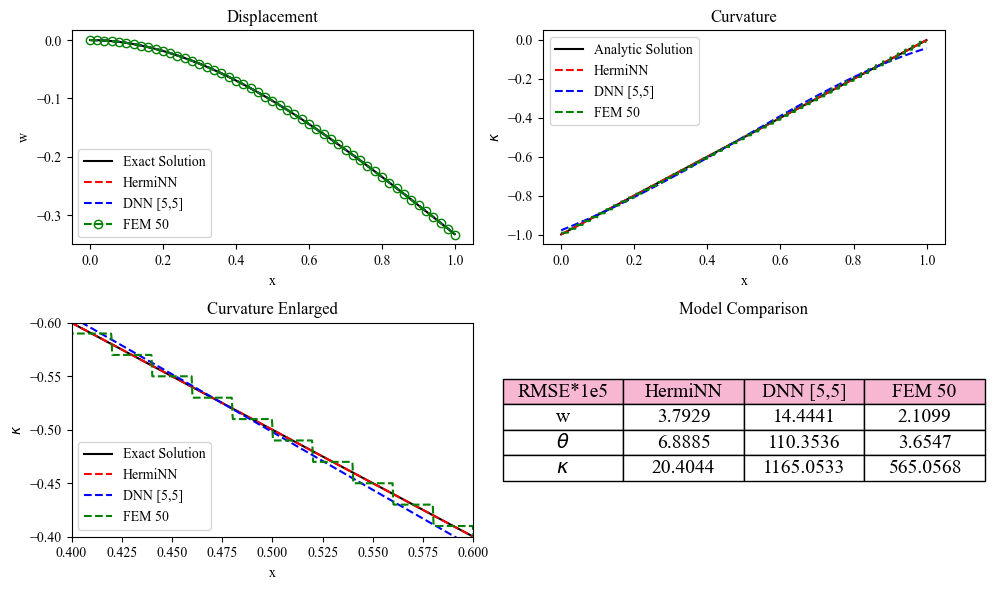

In [12]:

# Setting font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

import matplotlib.pyplot as plt
import pandas as pd

data_table = {
    'RMSE*1e5': ['w', r'$\theta$', r'$\kappa$'],
    'HermiNN': [f"{w_mse_Her**(1/2)*1e5:.4f}",f"{dw_mse_Her**(1/2)*1e5:.4f}",f"{d2w_mse_Her**(1/2)*1e5:.4f}"],
    'DNN [5,5]': [f"{w_mse_pinn**(1/2)*1e5:.4f}",f"{dw_mse_pinn**(1/2)*1e5:.4f}",f"{d2w_mse_pinn**(1/2)*1e5:.4f}"],
    'FEM 50': [f"{mse_fem**(1/2)*1e5:.4f}",f"{dw_mse_fem**(1/2)*1e5:.4f}",f"{d2w_mse_fem**(1/2)*1e5:.4f}"],
}

df = pd.DataFrame(data_table)

plt.figure(figsize=(10, 6))
#plt.style.use('default')

# Plot Displacement
plt.subplot(2, 2, 1)
plt.plot(x_fine, w_analytic, 'k-', label='Exact Solution')
plt.plot(data_np, w_np, 'r--', label='HermiNN')
plt.plot(data_np, w_pinn_np, 'b--', label='DNN [5,5]')
plt.plot(x_nodes, w_nodes, 'go--', mfc='none', label='FEM 50')
plt.xlabel('x')
plt.ylabel('w')
plt.legend(loc='lower left')
plt.title('Displacement')

'''
# Plot Slope
plt.subplot(2, 2, 2)
plt.plot(x_fine, dw_analytic, 'k-', label='Exact Solution')
plt.plot(data_np, dw_np, 'r--', label='HermiNN')
plt.plot(data_np, dw_pinn_np, 'b--', label='DNN [5,5]')
plt.plot(x_nodes, dw_nodes, 'go--', mfc='none', label='FEM 50')
plt.xlabel('x')
plt.ylabel(r'$\theta$')
plt.legend(loc='upper right')
plt.title('Slope')
'''

# Plot Curvature
plt.subplot(2, 2, 2)
plt.plot(x_fine, d2w_analytic, 'k-', label='Analytic Solution')
plt.plot(data_np, d2w_np, 'r--', label='HermiNN')
plt.plot(data_np, d2w_pinn_np, 'b--', label='DNN [5,5]')
plt.plot(x_fine, d2w_fem_interp, 'g--', mfc='none', label='FEM 50')
plt.xlabel('x')
plt.ylabel(r'$\kappa$')
plt.legend(loc='upper left')
plt.title('Curvature')

# Plot Curvature Zoom
plt.subplot(2, 2, 3)
plt.plot(x_fine, d2w_analytic, 'k-', label='Exact Solution')
plt.plot(data_np, d2w_np, 'r--', label='HermiNN')
plt.plot(data_np, d2w_pinn_np, 'b--', label='DNN [5,5]')
plt.plot(x_fine, d2w_fem_interp, 'g--', mfc='none', label='FEM 50')
plt.xlabel('x')
plt.ylabel(r'$\kappa$')
plt.legend(loc='lower left')
plt.title('Curvature Enlarged')
plt.xlim(0.4, 0.6)
plt.ylim(-0.4, -0.6)

# Add table
plt.subplot(2, 2, 4)
plt.axis('off')
tbl = plt.table(cellText=df.values, colLabels=df.columns, cellLoc = 'center', loc='center', colColours=["#f7b6d2"]*len(df.columns))
tbl.auto_set_font_size(False)
tbl.set_fontsize(14)
tbl.scale(1.2, 1.5)
plt.title('Model Comparison')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


In [13]:
def train_data_grid(Nx, Ny):
    # Generate x and y coordinates
    x = np.linspace(-1, 1, Nx)
    y = np.linspace(-1, 1, Ny)

    # Use meshgrid to generate grid points
    X, Y = np.meshgrid(x, y)

    # Transform grid points into (N, 2) shape
    Xf = np.vstack([X.ravel(), Y.ravel()]).T

    # Convert to PyTorch tensor
    Xf = torch.tensor(Xf, dtype=torch.float32, requires_grad=True)

    return Xf

def train_data(Nf, seed=None):
    if seed is not None:
        np.random.seed(seed)

    Xf2 = np.random.rand(Nf, 2) * 2 - 1

    '''
    while True:
        Xf2 = np.random.rand(Nf, 2) * 2 - 1
        # eliminate points at boundary
        Xf2 = Xf2[~((np.isclose(Xf2[:, 0], -1) | np.isclose(Xf2[:, 0], 1)) |
                    (np.isclose(Xf2[:, 1], -1) | np.isclose(Xf2[:, 1], 1)))]
        if len(Xf2) >= Nf:
            break
    Xf2 = Xf2[:Nf]
    '''
    Xf2 = torch.tensor(Xf2, dtype=torch.float32, requires_grad=True)

    return Xf2

In [160]:
# 2nd order derivative
def Laplace_w(xy, w):
    dw_xy = torch.autograd.grad(w, xy, grad_outputs=torch.ones_like(w), create_graph=True, retain_graph=True)
    dw_x = dw_xy[0][:,0]
    dw_y = dw_xy[0][:,1]

    dw_x_xy = torch.autograd.grad(dw_x, xy, grad_outputs=torch.ones_like(dw_x), create_graph=True, retain_graph=True)
    dw_xx = dw_x_xy[0][:,0]
    dw_xy = dw_x_xy[0][:,1]

    dw_y_xy = torch.autograd.grad(dw_y, xy, grad_outputs=torch.ones_like(dw_y), create_graph=True, retain_graph=True)
    dw_yy = dw_y_xy[0][:,1]

    return dw_x, dw_y, dw_xx, dw_xy, dw_yy


def TPE_PlaneStress(xy, w):
    _, _, dw_xx, dw_xy, dw_yy = Laplace_w(xy, w)

    #U_b = D / 2 * ((dw_xx+dw_yy)**2 + 2*(1-mu)*(dw_xy**2 - dw_xx*dw_yy))
    U_b = D / 2 * ((dw_xx+dw_yy)**2)

    U_e = q*w

    #print(U_b.shape), print(U_e.shape)

    return torch.mean(U_b), torch.mean(U_e)


In [161]:
# Problem Statement for Plane Stress
a = 1.0       # m, half transverse length
b = 1.0       # m, half longitudinal length
h = 0.001   # m, thickness
q = 1.0   # N/m^2, body force
E = 206e9     # 10^9 N/m^2
mu = 0.3    # Poisson's ratio
D = E * (h**3) / (12*(1-mu**2))

# Sampling coordinate data
num_sample_points = 5000

# Initializing Network
n_segments = 6
net_x = HiNet_hermit(-1, 1, n_segments, 'f', 'f')
net_y = HiNet_hermit(-1, 1, n_segments, 'f', 'f')

# Define Displacement Field
def Net_w(x):
    output = net_x(x[:,0]) * net_y(x[:,1])
    output *= h
    return output

# Optimizer Settings
params = []
params += list(net_x.parameters()) + list(net_y.parameters())
optimizer = optim.LBFGS(params, lr=0.5, max_iter=10, history_size=5)
num_epochs = 5

seed = 42 # for random sampling data
start_time_ml = time.time()

for epoch in range(num_epochs):

    data = train_data(num_sample_points, seed=seed)

    def closure():
        optimizer.zero_grad()
        w=Net_w(data)
        U, V = TPE_PlaneStress(data, w)
        loss = U - V
        loss.backward()
        return loss

    loss=optimizer.step(closure)
    
    seed += 1

    if (epoch + 1) % 1 == 0:
        print(f'epoch:{epoch + 1}, Total loss:{loss.item():.4e},')

end_time_ml = time.time()

# Arrange Trained Data
print(f'Time Consumed: {end_time_ml - start_time_ml:.4} seconds')

print('\n----------------------------------------------------------------')
print(f'Maximum Displacement: {max(Net_w(data).detach().numpy()):.4e}m')
print(f'Analytic Series Solution for Clamped Plate: {1.265319087 / 1000 * 16 * (q * a**4 /D):.4e}m')
print(f'Analytic Series Solution for S-S Plate: {0.0649984 * (q * a**4 /D):.4e}m')


epoch:1, Total loss:3.4649e-03,
epoch:2, Total loss:-5.2401e-06,
epoch:3, Total loss:-1.3126e-04,
epoch:4, Total loss:-1.6384e-04,
epoch:5, Total loss:-1.6825e-04,
Time Consumed: 3.481 seconds

----------------------------------------------------------------
Maximum Displacement: 1.0711e-03m
Analytic Series Solution for Clamped Plate: 1.0732e-03m
Analytic Series Solution for S-S Plate: 3.4455e-03m


In [162]:
'''

# Problem Statement for Plane Stress
a = 1.0       # m, half transverse length
b = 1.0       # m, half longitudinal length
h = 0.001   # m, thickness
q = 1.0    # N/m^2, body force
E = 206e9     # 10^9 N/m^2
mu = 0.3    # Poisson's ratio
D = E * (h**3) / (12*(1-mu**2))

# Sampling coordinate data
num_sample_points = 5000

# Initializing Network
n_segments = 6
net = PINN(2, 1, 30, 30)
BC_f = lambda x: (x+1)**2 * (x-1)**2

# Define Displacement Field
def Net_w(x):
    output = net(x)
    output *= BC_f(x[:,0]).view(-1,1) * BC_f(x[:,1]).view(-1,1)
    output *= h
    return output

# Optimizer Settings
params = []
params += list(net.parameters())
optimizer = optim.LBFGS(params, lr=0.1, max_iter=10, history_size=5)
num_epochs = 50

seed = 42 # for random sampling data
start_time_ml = time.time()

for epoch in range(num_epochs):

    data = train_data(num_sample_points, seed=seed)
    
    def closure():
        optimizer.zero_grad()
        w=Net_w(data)
        U, V = TPE_PlaneStress(data, w)
        loss = U - V
        loss.backward()
        return loss

    loss=optimizer.step(closure)
    
    seed += 1

    if (epoch + 1) % 5 == 0:
        print(f'epoch:{epoch + 1}, Total loss:{loss.item():.4e},')

end_time_ml = time.time()

# Arrange Trained Data
print(f'Time Consumed: {end_time_ml - start_time_ml:.4} seconds')

#print('\n----------------------------------------------------------------')
print(f'Maximum Displacement: {max(Net_w(data).detach().numpy()[:,0]):.4e}m')
print(f'Analytic Series Solution for Clamped Plate: {1.265319087 / 1000 * 16 * (q * a**4 /D):.4e}m')
#print(f'Analytic Series Solution for S-S Plate: {0.0649984 * (q * a**4 /D):.4e}m')

'''

"\n\n# Problem Statement for Plane Stress\na = 1.0       # m, half transverse length\nb = 1.0       # m, half longitudinal length\nh = 0.001   # m, thickness\nq = 1.0    # N/m^2, body force\nE = 206e9     # 10^9 N/m^2\nmu = 0.3    # Poisson's ratio\nD = E * (h**3) / (12*(1-mu**2))\n\n# Sampling coordinate data\nnum_sample_points = 5000\n\n# Initializing Network\nn_segments = 6\nnet = PINN(2, 1, 30, 30)\nBC_f = lambda x: (x+1)**2 * (x-1)**2\n\n# Define Displacement Field\ndef Net_w(x):\n    output = net(x)\n    output *= BC_f(x[:,0]).view(-1,1) * BC_f(x[:,1]).view(-1,1)\n    output *= h\n    return output\n\n# Optimizer Settings\nparams = []\nparams += list(net.parameters())\noptimizer = optim.LBFGS(params, lr=0.1, max_iter=10, history_size=5)\nnum_epochs = 50\n\nseed = 42 # for random sampling data\nstart_time_ml = time.time()\n\nfor epoch in range(num_epochs):\n\n    data = train_data(num_sample_points, seed=seed)\n    \n    def closure():\n        optimizer.zero_grad()\n        w=Net

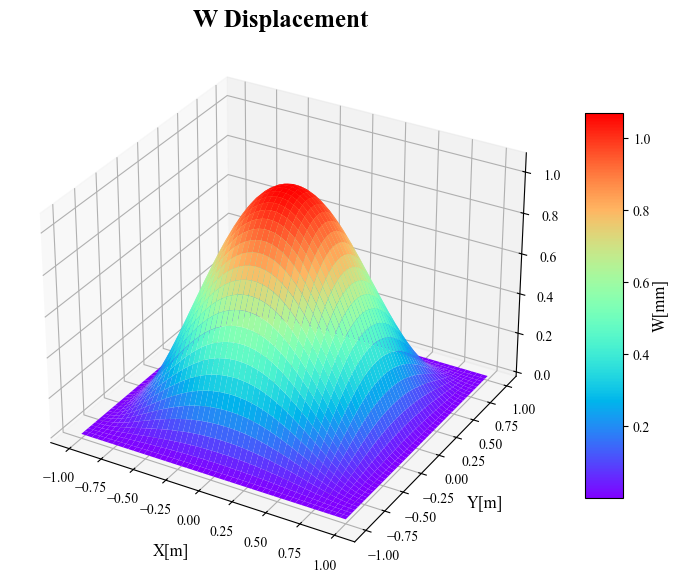

In [163]:
# Generate displacement fields
data = train_data_grid(50, 50)
w = Net_w(data).detach().numpy()

# Reshape data for plotting
x = data[:, 0].detach().numpy() * a
y = data[:, 1].detach().numpy() * b

# Create a meshgrid for plotting
X, Y = np.meshgrid(np.unique(x), np.unique(y))
W = w.reshape(X.shape)

# Setting font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# Plotting the results
fig = plt.figure(figsize=(14, 8))

# Plot W displacement
ax3 = fig.add_subplot(121, projection='3d')
surf = ax3.plot_surface(X, Y, W*1000, cmap='rainbow')
ax3.set_title('W Displacement',fontsize=18,fontweight='bold')
ax3.set_xlabel('X[m]',fontsize=12,labelpad=10)
ax3.set_ylabel('Y[m]',fontsize=12,labelpad=10)


# colorbar
cbar = fig.colorbar(surf, ax=ax3, shrink=0.5, aspect=10)
cbar.set_label('W[mm]',fontsize=12, labelpad=2)
cbar.ax.xaxis.set_label_position('bottom')

plt.tight_layout()
plt.show()

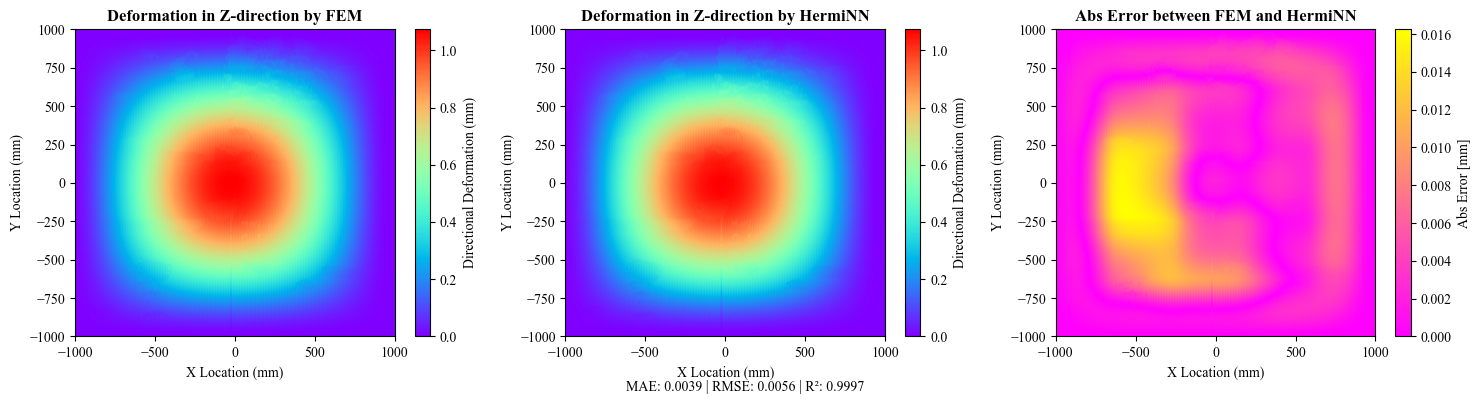

MAE: 0.0039 | RMSE: 0.0056 | R²: 0.9997


In [164]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 파일 경로
file_path = 'FEM/Clamped_Plate_10mm mesh_W.txt'

# 데이터 로드
data = pd.read_csv(file_path, delimiter='\t')

# X와 Y 데이터 추출 및 정렬
data_sorted = data.sort_values(by=['X Location (mm)', 'Y Location (mm)'])
x_sorted = data_sorted['X Location (mm)']
y_sorted = data_sorted['Y Location (mm)']
w_sorted = data_sorted['Directional Deformation (mm)']

coords = torch.tensor(np.column_stack((x_sorted / 1000, y_sorted / 1000)), dtype=torch.float32)
w_herminn = 1000 * Net_w(coords).detach().numpy()

# 데이터 프레임에 새로운 컬럼 추가
data_sorted['Directional Deformation HermiNN (mm)'] = w_herminn

# 오차 계산
data_sorted['Error'] = abs(data_sorted['Directional Deformation (mm)'] - \
                                   data_sorted['Directional Deformation HermiNN (mm)'])

# MSE, RMSE, MAE, R² 계산
mse = mean_squared_error(data_sorted['Directional Deformation (mm)'], data_sorted['Directional Deformation HermiNN (mm)'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(data_sorted['Directional Deformation (mm)'], data_sorted['Directional Deformation HermiNN (mm)'])
r2 = r2_score(data_sorted['Directional Deformation (mm)'], data_sorted['Directional Deformation HermiNN (mm)'])

# Setting font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# 컬러바 스케일 통일을 위한 범위 설정
vmin = min(w_sorted.min(), w_herminn.min())
vmax = max(w_sorted.max(), w_herminn.max())
error_vmin = data_sorted['Error'].min()
error_vmax = data_sorted['Error'].max()

# 플롯 그리기
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# 첫 번째 2D contour 플롯
sc1 = axs[0].scatter(x_sorted, y_sorted, c=w_sorted, cmap='rainbow', marker='o', vmin=vmin, vmax=vmax)
fig.colorbar(sc1, ax=axs[0], label='Directional Deformation (mm)')
axs[0].set_title('Deformation in Z-direction by FEM', fontweight='bold')
axs[0].set_xlabel('X Location (mm)')
axs[0].set_ylabel('Y Location (mm)')
axs[0].set_xlim([-1000, 1000])
axs[0].set_ylim([-1000, 1000])

# 두 번째 2D scatter 플롯
sc2 = axs[1].scatter(x_sorted, y_sorted, c=w_herminn, cmap='rainbow', marker='o', vmin=vmin, vmax=vmax)
fig.colorbar(sc2, ax=axs[1], label='Directional Deformation (mm)')
axs[1].set_title('Deformation in Z-direction by HermiNN', fontweight='bold')
axs[1].set_xlabel('X Location (mm)')
axs[1].set_ylabel('Y Location (mm)')
axs[1].set_xlim([-1000, 1000])
axs[1].set_ylim([-1000, 1000])

# 세 번째 2D scatter 플롯 (오차 분석)
sc3 = axs[2].scatter(x_sorted, y_sorted, c=data_sorted['Error'], cmap='spring', marker='o', vmin=error_vmin, vmax=error_vmax)
fig.colorbar(sc3, ax=axs[2], label='Abs Error [mm]')
axs[2].set_title('Abs Error between FEM and HermiNN', fontweight='bold')
axs[2].set_xlabel('X Location (mm)')
axs[2].set_ylabel('Y Location (mm)')
axs[2].set_xlim([-1000, 1000])
axs[2].set_ylim([-1000, 1000])

# MSE, RMSE, MAE, R² 표시
plt.figtext(0.5, 0.01, f'MAE: {mae:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print(f'MAE: {mae:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}')


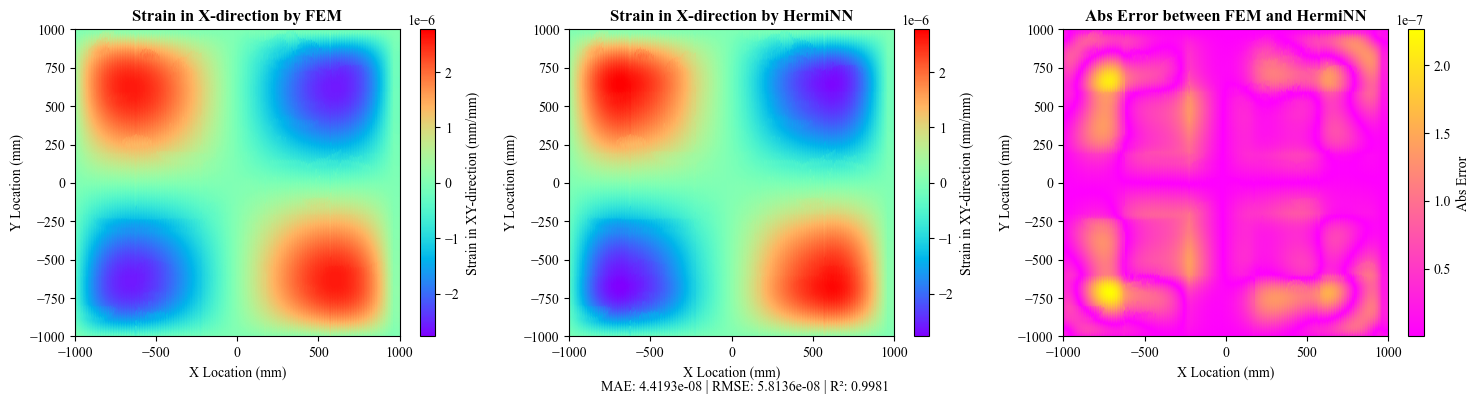

MAE: 4.4193e-08 | RMSE: 5.8136e-08 | R²: 0.9981


In [165]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 파일 경로
file_path = 'FEM/Clamped_Plate_10mm mesh_eps_xy.txt'

# 데이터 로드
data = pd.read_csv(file_path, delimiter='\t')
data = data[::2]

data = data[(data.iloc[:, 1] != -200) & (data.iloc[:, 2] != -200) \
            & (data.iloc[:, 1] != 200) & (data.iloc[:, 2] != 200)]
data = data[(data.iloc[:, 1] != -600) & (data.iloc[:, 2] != -600) \
            & (data.iloc[:, 1] != 600) & (data.iloc[:, 2] != 600)]
data = data[(data.iloc[:, 1] != -1000) & (data.iloc[:, 2] != -1000) \
            & (data.iloc[:, 1] != 1000) & (data.iloc[:, 2] != 1000)]
#data = data[(data.iloc[:, 1] != 0.) & (data.iloc[:, 2] != 0.)]

# X와 Y 데이터 추출 및 정렬
data_sorted = data.sort_values(by=['X Location (mm)', 'Y Location (mm)'])
x_sorted = data_sorted['X Location (mm)']
y_sorted = data_sorted['Y Location (mm)']
exx_sorted = data_sorted['Shear Elastic Strain (mm/mm)']

coords = torch.tensor(np.column_stack((x_sorted / 1000, y_sorted/ 1000)), dtype=torch.float32, requires_grad=True)
w = Net_w(coords)

_, _, _, dw_xy, _ = Laplace_w(coords, w)

exx = - h * dw_xy

exx_herminn = exx.detach().numpy()

# 데이터 프레임에 새로운 컬럼 추가
data_sorted['Shear Elastic Strain HermiNN (mm/mm)'] = exx_herminn

# 오차 계산
data_sorted['Error'] = abs((data_sorted['Shear Elastic Strain (mm/mm)'] - \
                            data_sorted['Shear Elastic Strain HermiNN (mm/mm)']))

# MSE, MAE, R² 계산
mse = mean_squared_error(data_sorted['Shear Elastic Strain (mm/mm)'], data_sorted['Shear Elastic Strain HermiNN (mm/mm)'])
mae = mean_absolute_error(data_sorted['Shear Elastic Strain (mm/mm)'], data_sorted['Shear Elastic Strain HermiNN (mm/mm)'])
r2 = r2_score(data_sorted['Shear Elastic Strain (mm/mm)'], data_sorted['Shear Elastic Strain HermiNN (mm/mm)'])

# Setting font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# 플롯 그리기
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# 컬러바 통일을 위한 vmin과 vmax 설정
vmin = min(min(exx_sorted), min(exx_herminn))
vmax = max(max(exx_sorted), max(exx_herminn))

# 첫 번째 2D scatter 플롯
sc1 = axs[0].scatter(x_sorted, y_sorted, c=exx_sorted, cmap='rainbow', marker='o', vmin=vmin, vmax=vmax)
fig.colorbar(sc1, ax=axs[0], label='Strain in XY-direction (mm/mm)')
axs[0].set_title('Strain in X-direction by FEM', fontweight='bold')
axs[0].set_xlabel('X Location (mm)')
axs[0].set_ylabel('Y Location (mm)')
axs[0].set_xlim([-1000, 1000])
axs[0].set_ylim([-1000, 1000])

# 두 번째 2D scatter 플롯 (excluding zero values)
sc2 = axs[1].scatter(x_sorted, y_sorted, c=exx_herminn, cmap='rainbow', marker='o', vmin=vmin, vmax=vmax)
fig.colorbar(sc2, ax=axs[1], label='Strain in XY-direction (mm/mm)')
axs[1].set_title('Strain in X-direction by HermiNN', fontweight='bold')
axs[1].set_xlabel('X Location (mm)')
axs[1].set_ylabel('Y Location (mm)')
axs[1].set_xlim([-1000, 1000])
axs[1].set_ylim([-1000, 1000])

# 세 번째 2D scatter 플롯 (오차 분석)
sc3 = axs[2].scatter(x_sorted, y_sorted, c=data_sorted['Error'], cmap='spring', marker='o')
fig.colorbar(sc3, ax=axs[2], label='Abs Error')
axs[2].set_title('Abs Error between FEM and HermiNN', fontweight='bold')
axs[2].set_xlabel('X Location (mm)')
axs[2].set_ylabel('Y Location (mm)')
axs[2].set_xlim([-1000, 1000])
axs[2].set_ylim([-1000, 1000])

# MSE, MAE, R² 표시
plt.figtext(0.5, 0.01, f'MAE: {mae:.4e} | RMSE: {np.sqrt(mse):.4e} | R²: {r2:.4f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print(f'MAE: {mae:.4e} | RMSE: {np.sqrt(mse):.4e} | R²: {r2:.4f}')


In [248]:
# Problem Statement for Plane Stress
a = 1.0       # m, half transverse length
b = 1.0       # m, half longitudinal length
h = 0.001   # m, thickness
q = 0.0   # N/m^2, body force
E = 206e9     # 10^9 N/m^2
mu = 0.3    # Poisson's ratio
D = E * (h**3) / (12*(1-mu**2))

# Sampling coordinate data
num_sample_points = 5000

# Initializing Network
n_segments = 6
net_x = HiNet_hermit(-1, 1, n_segments, 'f', 'f')
net_y = HiNet_hermit(-1, 1, n_segments, 'f', 'f')

# Define Displacement Field
def Net_w(x):
    output = net_x(x[:,0]) * net_y(x[:,1])
    output *= h
    return output

# Optimizer Settings
params = []
params += list(net_x.parameters()) + list(net_y.parameters())
optimizer = optim.LBFGS(params, lr=0.5, max_iter=10, history_size=5)
num_epochs = 5

seed = 42 # for random sampling data
start_time_ml = time.time()

errors = []  # List to store errors for plotting
qs = []

for q_epoch in range(50):

    for epoch in range(num_epochs):

        data = train_data(num_sample_points, seed=seed)

        def closure():
            optimizer.zero_grad()
            w=Net_w(data)
            U, V = TPE_PlaneStress(data, w)
            loss = U - V
            loss.backward()
            return loss

        loss=optimizer.step(closure)
        
        seed += 1

        if (epoch + 1) % 6 == 0:
            print(f'epoch:{epoch + 1}, Total loss:{loss.item():.4e},')
    
    fdsa= Net_w(torch.tensor([[0.,0.]])).detach()
    #print(fdsa)
    error = 1.0732 - fdsa[0] * 1000
    errors.append(abs(error))  # Record the error
    qs.append(abs(q - 1))

    #print(error)
    print(f'q Epoch: {q_epoch+1}, Error with Given: {abs(error):.4e}, q error: {abs(q-1):.4e}')
    
    if abs(error) > 1e-3:
        q += (error)
    else:
        break

print(q)

end_time_ml = time.time()

print(f"Training time: {(end_time_ml - start_time_ml):.4e} seconds")

q Epoch: 1, Error with Given: 1.0732e+00, q error: 1.0000e+00


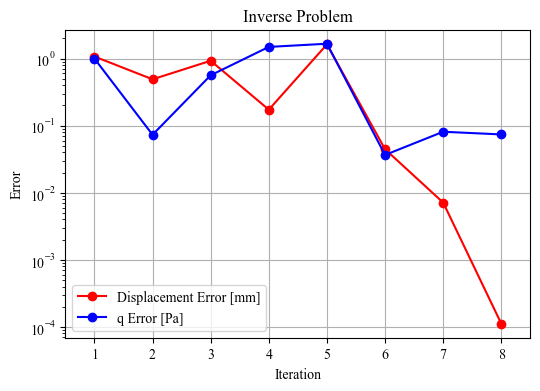

Training time: 1.9642e+01 seconds
1.0731e-03
tensor(1.0741)


In [ ]:
# Plotting the error
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(errors) + 1), errors, 'ro-', label='Displacement Error [mm]')
plt.plot(range(1, len(qs) + 1), qs, 'bo-', label='q Error [Pa]')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Inverse Problem')
plt.grid(True)
plt.yscale('log')
plt.legend()
plt.xlim([0.5,8.5])
plt.show()

print(f"Training time: {(end_time_ml - start_time_ml):.4e} seconds")
print(f"{Net_w(torch.tensor([[0.,0.]])).detach()[0]:.4e}")
print(q)

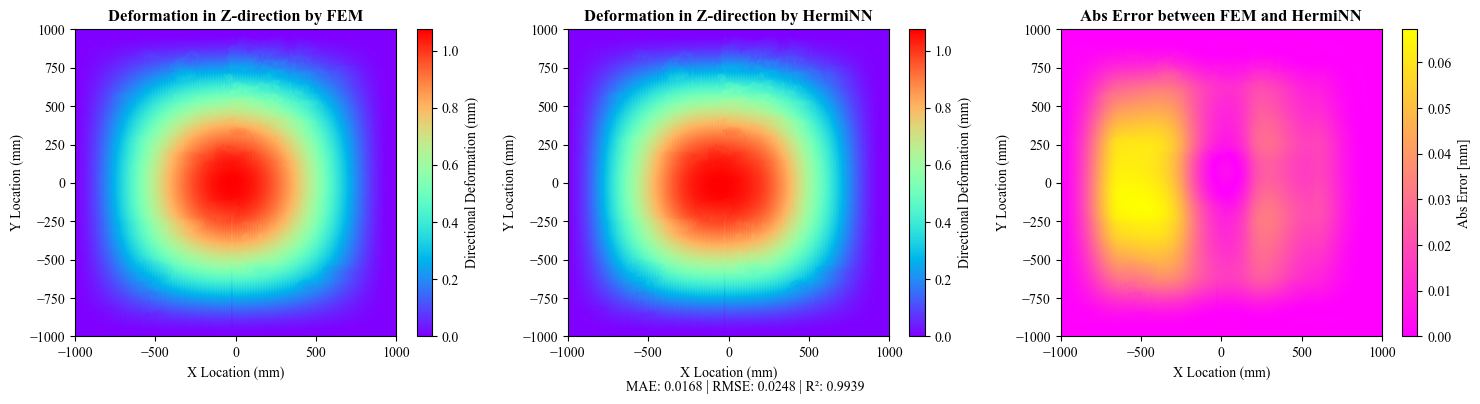

MAE: 0.0168 | RMSE: 0.0248 | R²: 0.9939


In [240]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 파일 경로
file_path = 'FEM/Clamped_Plate_10mm mesh_W.txt'

# 데이터 로드
data = pd.read_csv(file_path, delimiter='\t')

# X와 Y 데이터 추출 및 정렬
data_sorted = data.sort_values(by=['X Location (mm)', 'Y Location (mm)'])
x_sorted = data_sorted['X Location (mm)']
y_sorted = data_sorted['Y Location (mm)']
w_sorted = data_sorted['Directional Deformation (mm)']

coords = torch.tensor(np.column_stack((x_sorted / 1000, y_sorted / 1000)), dtype=torch.float32)
w_herminn = 1000 * Net_w(coords).detach().numpy()

# 데이터 프레임에 새로운 컬럼 추가
data_sorted['Directional Deformation HermiNN (mm)'] = w_herminn

# 오차 계산
data_sorted['Error'] = abs(data_sorted['Directional Deformation (mm)'] - \
                                   data_sorted['Directional Deformation HermiNN (mm)'])

# MSE, RMSE, MAE, R² 계산
mse = mean_squared_error(data_sorted['Directional Deformation (mm)'], data_sorted['Directional Deformation HermiNN (mm)'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(data_sorted['Directional Deformation (mm)'], data_sorted['Directional Deformation HermiNN (mm)'])
r2 = r2_score(data_sorted['Directional Deformation (mm)'], data_sorted['Directional Deformation HermiNN (mm)'])

# Setting font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# 컬러바 스케일 통일을 위한 범위 설정
vmin = min(w_sorted.min(), w_herminn.min())
vmax = max(w_sorted.max(), w_herminn.max())
error_vmin = data_sorted['Error'].min()
error_vmax = data_sorted['Error'].max()

# 플롯 그리기
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# 첫 번째 2D contour 플롯
sc1 = axs[0].scatter(x_sorted, y_sorted, c=w_sorted, cmap='rainbow', marker='o', vmin=vmin, vmax=vmax)
fig.colorbar(sc1, ax=axs[0], label='Directional Deformation (mm)')
axs[0].set_title('Deformation in Z-direction by FEM', fontweight='bold')
axs[0].set_xlabel('X Location (mm)')
axs[0].set_ylabel('Y Location (mm)')
axs[0].set_xlim([-1000, 1000])
axs[0].set_ylim([-1000, 1000])

# 두 번째 2D scatter 플롯
sc2 = axs[1].scatter(x_sorted, y_sorted, c=w_herminn, cmap='rainbow', marker='o', vmin=vmin, vmax=vmax)
fig.colorbar(sc2, ax=axs[1], label='Directional Deformation (mm)')
axs[1].set_title('Deformation in Z-direction by HermiNN', fontweight='bold')
axs[1].set_xlabel('X Location (mm)')
axs[1].set_ylabel('Y Location (mm)')
axs[1].set_xlim([-1000, 1000])
axs[1].set_ylim([-1000, 1000])

# 세 번째 2D scatter 플롯 (오차 분석)
sc3 = axs[2].scatter(x_sorted, y_sorted, c=data_sorted['Error'], cmap='spring', marker='o', vmin=error_vmin, vmax=error_vmax)
fig.colorbar(sc3, ax=axs[2], label='Abs Error [mm]')
axs[2].set_title('Abs Error between FEM and HermiNN', fontweight='bold')
axs[2].set_xlabel('X Location (mm)')
axs[2].set_ylabel('Y Location (mm)')
axs[2].set_xlim([-1000, 1000])
axs[2].set_ylim([-1000, 1000])

# MSE, RMSE, MAE, R² 표시
plt.figtext(0.5, 0.01, f'MAE: {mae:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print(f'MAE: {mae:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}')
